## Importing libraries

In [1]:
# Preprocessing Imports
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
# Model Imports
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.get_device_name(0))   # Name of the GPU (e.g., Tesla T4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
Tesla T4


# System Identification

## Phase 1

### Generate data

In [13]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-10, 10, num_samples) # Input random
    # x = np.random.randint(-10, 10, num_samples) # Input random
    
    t = np.zeros(num_samples)
    t[0] = 0
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0     -4.058154  0.000000
1      4.137295  3.251770
2      3.231801 -0.346838
3     -9.723893 -2.507893
4     -0.397855  2.954887
...         ...       ...
29997 -1.690894 -1.011737
29998 -0.208106  0.949408
29999 -6.914326 -1.140214
30000  6.381176  4.104358
30001 -7.641037 -3.768576

[30002 rows x 2 columns]


### Data Preprocessing

In [15]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]
})  

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size input and output
print(X.shape, T.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0  3.231801  4.137295 -4.058154  3.251770  0.000000 -0.346838
1 -9.723893  3.231801  4.137295 -0.346838  3.251770 -2.507893
2 -0.397855 -9.723893  3.231801 -2.507893 -0.346838  2.954887
3  2.589276 -0.397855 -9.723893  2.954887 -2.507893  0.869436
4  8.562327  2.589276 -0.397855  0.869436  2.954887  1.933301
(30000, 6)
(30000, 5) (30000, 1)


In [17]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    X_train = X[:15000]
    T_train = T[:15000]

    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    X_test = X[20000:]
    T_test = T[20000:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


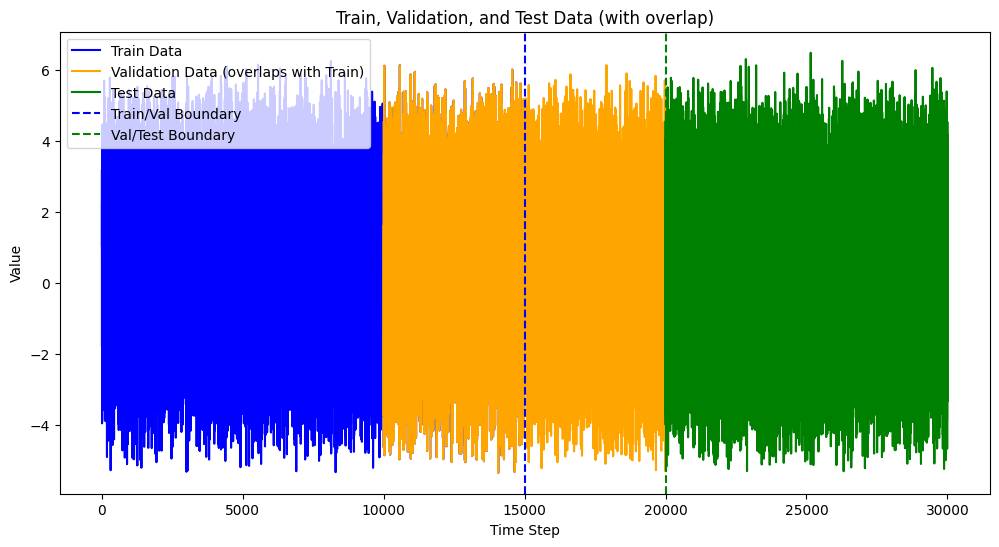

In [6]:
plt.figure(figsize=(12, 6))

# Define your index ranges explicitly
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = test_start + len(T_test)

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), T_train, label='Train Data', color='blue')
plt.plot(range(val_start, val_end), T_val, label='Validation Data (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_end, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data (with overlap)")

plt.show()

In [32]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = xscaler.fit_transform(T_train)
T_val_norm = xscaler.transform(T_val)
T_test_norm = xscaler.transform(T_test)

In [33]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### MLP Model

In [ ]:
input_dim = X_train.shape[1]    # 5
output_dim = T_train.shape[1]   # 1

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, output_dim)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.tanh(self.fc1(x))
    x = self.tanh(self.fc2(x))
    x = self.tanh(self.fc3(x))
    x = self.fc4(x)
    return x

model = MLP(input_dim, output_dim).to(device)

### Training and Validation

In [ ]:
# training setup
n_epochs = 25
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# validation setup
patience = 10

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, device="cpu"):
    history = {"train_loss":[], "val_loss":[], "accuracy":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
        
    return history, best_model_weights

history, best_model_weights = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, device)

Epoch 0: train MSE 0.000138, val MSE 0.000141
Epoch 1: train MSE 0.000126, val MSE 0.000208
Epoch 2: train MSE 0.000116, val MSE 0.000126
Epoch 3: train MSE 0.000118, val MSE 0.000124
Epoch 4: train MSE 0.000111, val MSE 0.000031
Epoch 5: train MSE 0.000110, val MSE 0.000035


In [ ]:
# Training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [ ]:
# Predictions
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
pred = []
with torch.no_grad():
  for i in range(len(Xtest)):
    x = Xtest[i]
    t = Ttest[i]
    pred = model(x)
    pred.append(pred.cpu())

print(pred.shape)
print(type(pred)) 
print(Ttest.shape) 
# hitung mse test dari yang sudah direscale

[  4.76476247 -16.98439723  45.4190527  ...   7.45175909 -32.44819043
   9.78453128]
[  4.82042854 -16.72532581  45.46225205 ...   7.3702104  -32.4797878
   9.74147114]
Test MSE: 0.05991292183285193


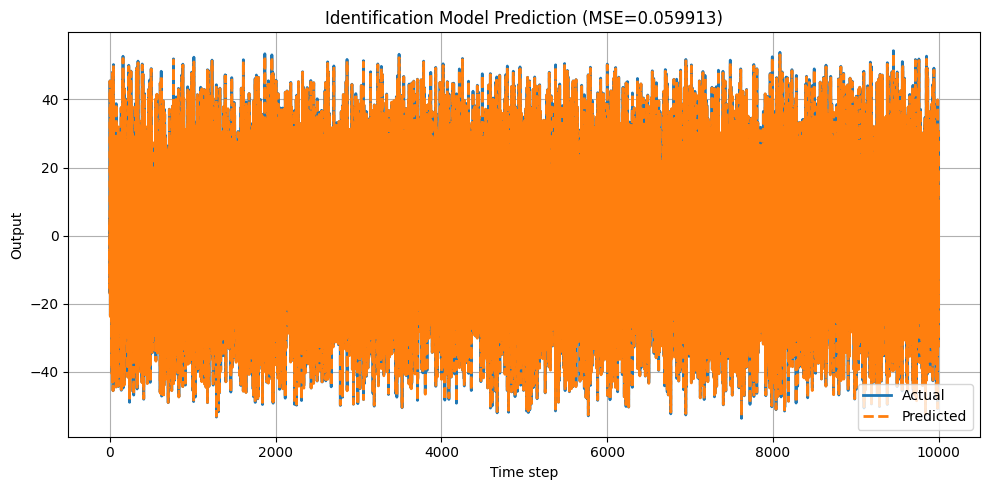

In [ ]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(ypred.flatten(), label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Phase 2

### Data Preprocessing

In [ ]:
# Generate dataset with lags
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]
})  

df_lagged = df_lagged.dropna().reset_index(drop=True)

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

        x(t)     x(t-1)     x(t-2)       t(t)
0 -49.490089  41.381131 -22.647335 -24.783831
1  91.315626 -49.490089  41.381131  37.677559
2  12.804434  91.315626 -49.490089 -24.192875
3 -42.609059  12.804434  91.315626 -14.491889
4  -8.547664 -42.609059  12.804434  10.650540
(30000, 4)


In [ ]:
# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   
T = df_lagged[["t(t)"]].values   

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


In [ ]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = xscaler.fit_transform(T_train)
T_val_norm = xscaler.transform(T_val)
T_test_norm = xscaler.transform(T_test)

In [ ]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### Training and validation

In [ ]:
# training setup
n_epochs = 25
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# validation setup
patience = 10

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, device="cpu"):
    history = {"train_loss":[], "val_loss":[], "accuracy":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        y_buffer = 
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")
        
    return history, best_model_weights

history, best_model_weights = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, device)

Epoch 1: train_loss=0.003018, val_loss=0.000182
Epoch 10: train_loss=0.000222, val_loss=0.000109
Epoch 20: train_loss=0.000024, val_loss=0.000021
Epoch 30: train_loss=0.000021, val_loss=0.000018
Epoch 40: train_loss=0.000019, val_loss=0.000016
Epoch 50: train_loss=0.000018, val_loss=0.000015
Epoch 60: train_loss=0.000018, val_loss=0.000015
Epoch 70: train_loss=0.000017, val_loss=0.000014
Epoch 80: train_loss=0.000017, val_loss=0.000014
Epoch 90: train_loss=0.000016, val_loss=0.000013
Epoch 100: train_loss=0.000016, val_loss=0.000013
Epoch 110: train_loss=0.000015, val_loss=0.000013
Epoch 120: train_loss=0.000015, val_loss=0.000012
Epoch 130: train_loss=0.000014, val_loss=0.000012
Epoch 140: train_loss=0.000014, val_loss=0.000012
Epoch 150: train_loss=0.000014, val_loss=0.000011
Epoch 160: train_loss=0.000013, val_loss=0.000011
Epoch 170: train_loss=0.000013, val_loss=0.000011
Epoch 180: train_loss=0.000013, val_loss=0.000011
Epoch 190: train_loss=0.000013, val_loss=0.000011
Epoch 200: 

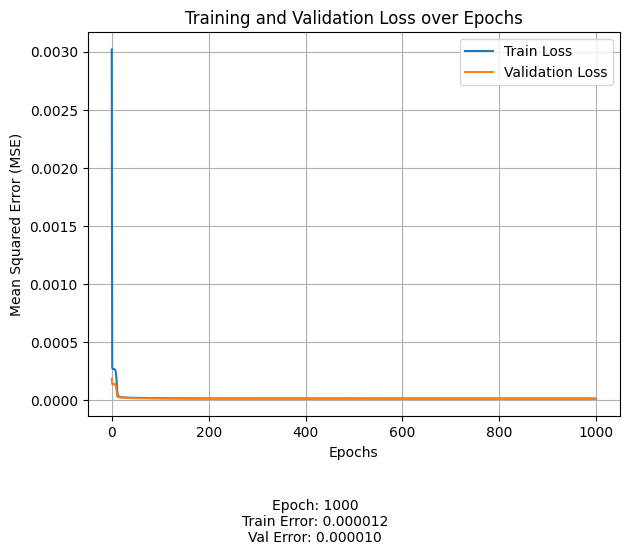

In [84]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [ ]:
from MyKeras.losses import mse

# testing
predictions = model2.predict(X_test_norm)
# mse_test = mse(predictions, T_test)

# print("Predictions:", predictions.flatten())
# print("Test MSE:", mse_test)
ypred = rescale(predictions, T_train)
mse_test = mse(ypred, T_test)
print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)

In [85]:
pred = model2.predict(X_test_norm)
ypred = rescale(pred, T_train)
print(ypred.flatten())
print(T_test.flatten())

# I'm gonna use my library to calculate MSE here
mse_test = mse(ypred.flatten(), T_test.flatten())
print("Test MSE:", mse_test)

[  3.80499532 -16.50976089  44.15957155 ...   6.66496306 -32.00580993
   7.30220731]
[  4.82042854 -16.72532581  45.46225205 ...   7.3702104  -32.4797878
   9.74147114]
Test MSE: 2.741868081577057


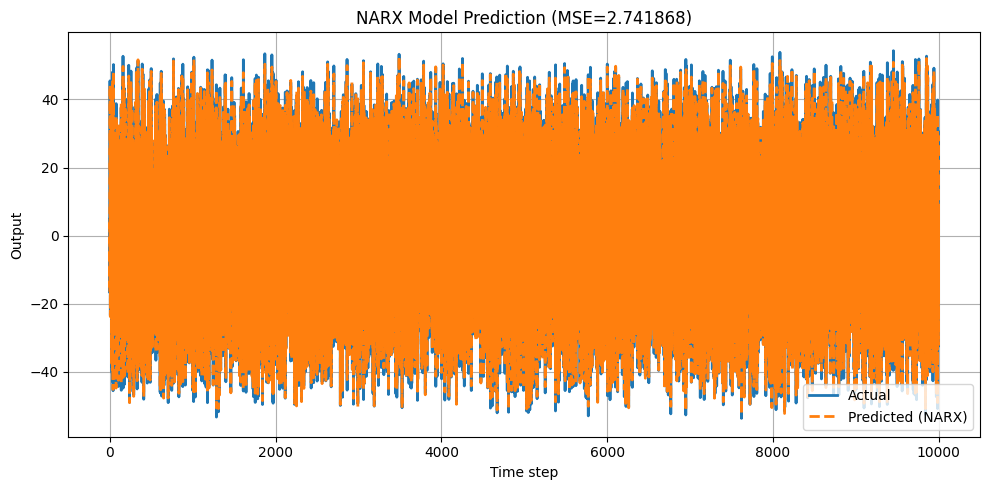

In [86]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(ypred.flatten(), label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()